<a href="https://colab.research.google.com/github/anilkumar8142556595/Skin-lesion-classification-using-CNN/blob/main/MINI_PROJ_CUSTOM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

# !pip install -q tensorflow==2.4.1

clear_output()

import os
import shutil
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed = 1
random.seed(seed)
#directory = '../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
images_path = Path('/content/drive/MyDrive/ISIC_2019_Training_Input_updates')
path_ground_truth_data = '/content/drive/MyDrive/Ground_Truth_100.csv'

In [ ]:
ground_truth_labels = pd.read_csv(path_ground_truth_data)
print(ground_truth_labels.head())

          image  MEL  NV  BCC  AK  BKL  DF  VASC  SCC  UNK
0  ISIC_0000000    0   1    0   0    0   0     0    0    0
1  ISIC_0000001    0   1    0   0    0   0     0    0    0
2  ISIC_0000002    1   0    0   0    0   0     0    0    0
3  ISIC_0000003    0   1    0   0    0   0     0    0    0
4  ISIC_0000004    1   0    0   0    0   0     0    0    0


In [ ]:
CLASSES = ground_truth_labels.columns[1:-1].values
print(CLASSES)

['MEL' 'NV' 'BCC' 'AK' 'BKL' 'DF' 'VASC' 'SCC']


## Get path images and get labels from **ground_truth_labels**

In [ ]:
images = [path.as_posix() for path in list(images_path.rglob("*jpg"))]
labels = list()
for path in tqdm(images):
    name = path.split('/')[-1].split('.')[0]
    label = ground_truth_labels[ground_truth_labels.image == name].iloc[:,1:].values.argmax()
    labels.append(label)
classes = len(np.unique(labels))
assert len(images)==len(labels), 'Not equal number images and labels'

100%|██████████| 94/94 [00:00<00:00, 1340.68it/s]


94 94


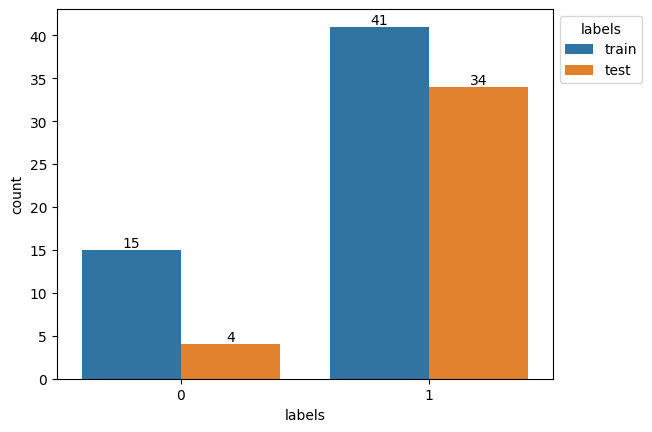

In [ ]:
number_validation_images = int(len(images) * 0.6)
train_images, train_labels = images[:number_validation_images], labels[:number_validation_images]
test_images, test_labels = images[number_validation_images:], labels[number_validation_images:]

cur_labels = train_labels + test_labels
splits = ['train' for _ in range(len(train_labels))] + ['test' for _ in range(len(test_labels))]
print(len(labels), len(splits))
df = pd.DataFrame(list(zip(cur_labels, splits)),
               columns =['labels', 'splits'])

p = sns.countplot(data=df, x='labels', hue='splits')
p.legend(title='labels', bbox_to_anchor=(1, 1), loc='upper left')

for c in p.containers:
    # set the bar label
    p.bar_label(c, fmt='%.0f', label_type='edge')

In [ ]:

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [260, 260], 'nearest')
#     image /= 255
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label

#Creating TensorFlow Datasets for Training and Testing
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(10).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(10).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Converting Batch to NumPy Arrays
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels
#Creating Title from Label and Target
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
#Displaying a Single Image with Title
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
#Displaying a Batch of Images
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

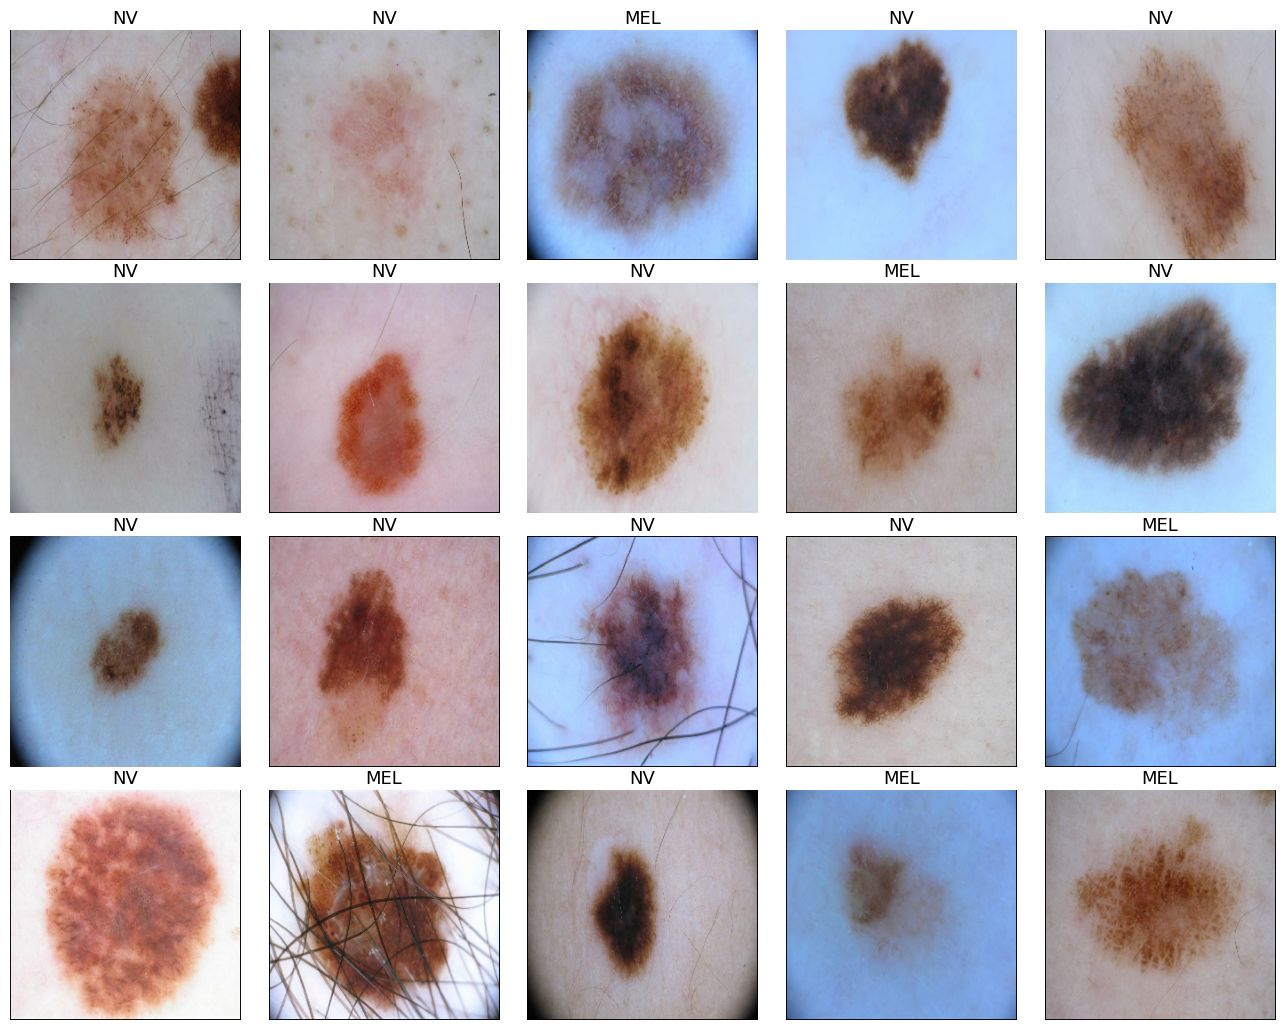

In [ ]:
ds_iter = next(iter(train_ds.unbatch().batch(20)))
display_batch_of_images(ds_iter)

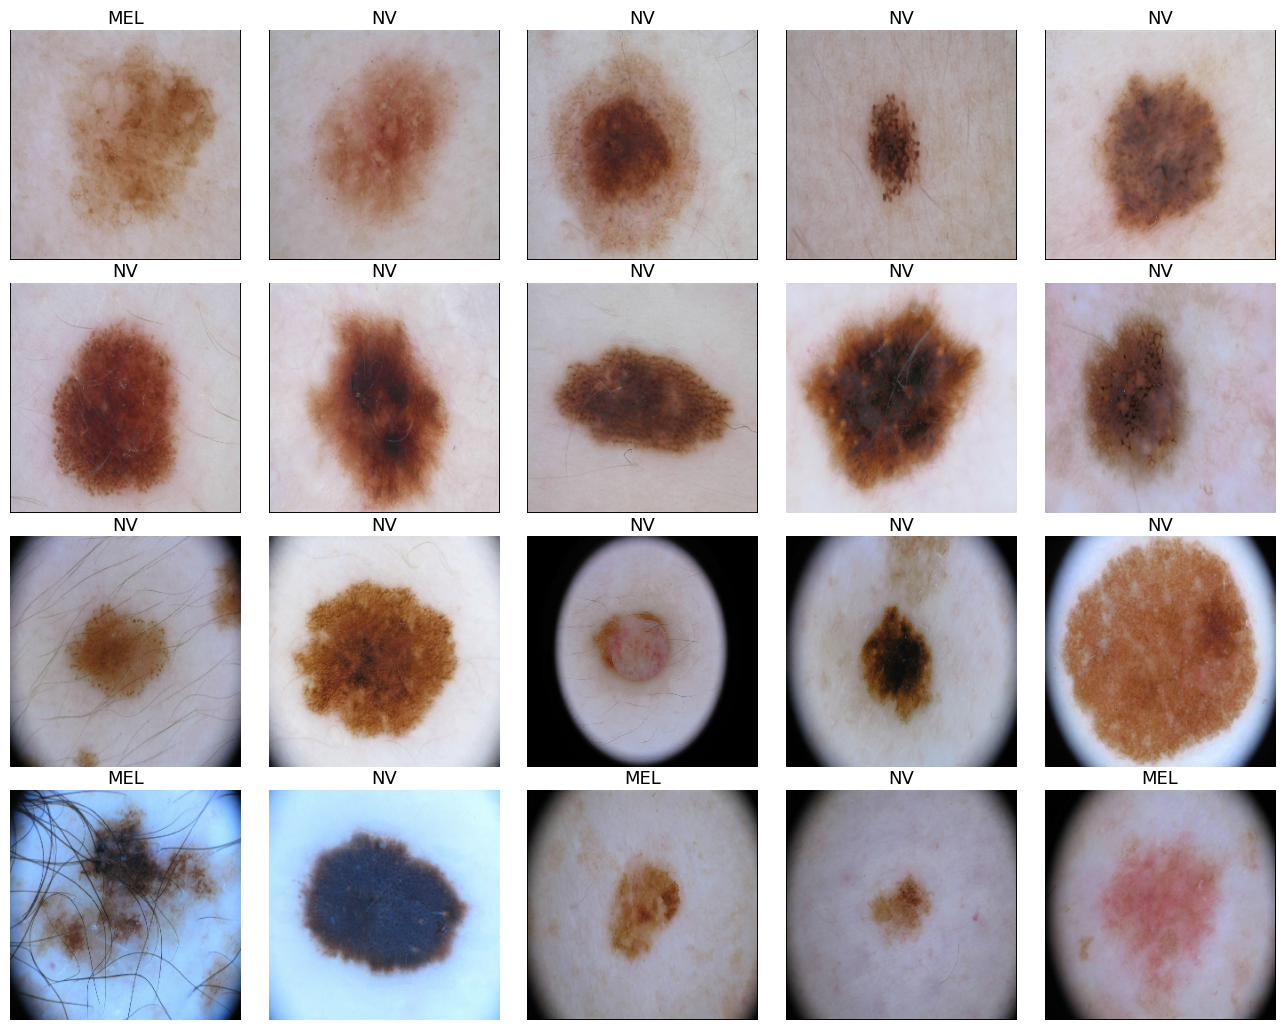

In [ ]:
ds_iter = next(iter(test_ds.unbatch().batch(20)))
display_batch_of_images(ds_iter)

Learning rate schedule: 1e-05 to 5e-05 to 1.14e-05


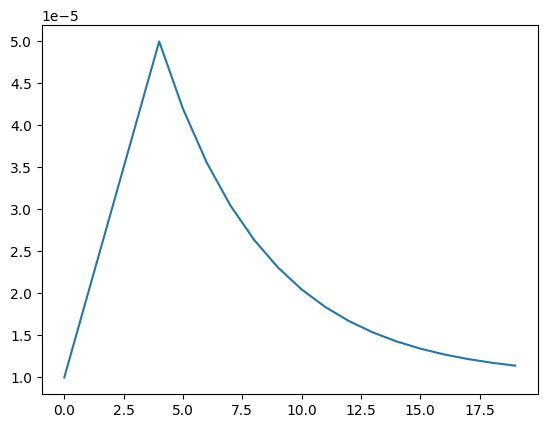

In [ ]:

#Define Learning Rate Parameters
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 20
#Learning Rate Function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
#Learning Rate Scheduler Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
#Visualize Learning Rate Schedule
#Visualize Learning Rate Schedule
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow import keras
model = keras.applications.EfficientNetB2(weights='/content/drive/MyDrive/efficientnetb2.h5 (1)/efficientnetb2.h5', include_top=True)

model.trainable = False
# for input you can also do model.input,
# then for base_outputs you can obviously
# choose other than simply removing the last one :)
base_inputs = model.layers[0].input
base_outputs = model.layers[-1].output
classifier = layers.Dense(classes)(base_outputs)
new_model = keras.Model(inputs=base_inputs, outputs=classifier)


new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=False),],
    metrics=["accuracy"],
)

# print(new_model.summary())

history = new_model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=32,
    epochs=EPOCHS,
    verbose=1
)

ValueError: `inputs` argument cannot be empty. Received:
inputs=[]
outputs=<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_342>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.applications.EfficientNetB2(weights='/content/drive/MyDrive/efficientnetb2.h5 (1)/efficientnetb2.h5', include_top=True)

model.trainable = False

# Instead of accessing the input layer directly, use model.input
base_inputs = model.input  # This should correctly get the input tensor
base_outputs = model.layers[-2].output # Select the output from the second to last layer
classifier = layers.Dense(classes)(base_outputs)
new_model = keras.Model(inputs=base_inputs, outputs=classifier)

new_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=False),],
    metrics=["accuracy"],
)

history = new_model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=32,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5078 - loss: 4.8061 - val_accuracy: 0.8947 - val_loss: 1.7703
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6770 - loss: 2.9181 - val_accuracy: 0.8947 - val_loss: 1.1127
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7529 - loss: 2.2323 - val_accuracy: 0.8947 - val_loss: 1.1504
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7116 - loss: 2.3045 - val_accuracy: 0.8947 - val_loss: 1.1657
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7005 - loss: 1.4262 - val_accuracy: 0.8947 - val_loss: 1.1873
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6283 - loss: 2.2139 - val_accuracy: 0.8947 - val_loss: 1.1957
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7438 - loss: 0.6700 - val_accuracy: 0.8947 - val_loss: 1.1927
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6584 - loss: 0.8911 - val_accuracy: 0.8947 - val_loss: 1.2008
Epoch 9/

In [ ]:
model.save('model.keras')

<ipython-input-31-18338ed3eb04>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


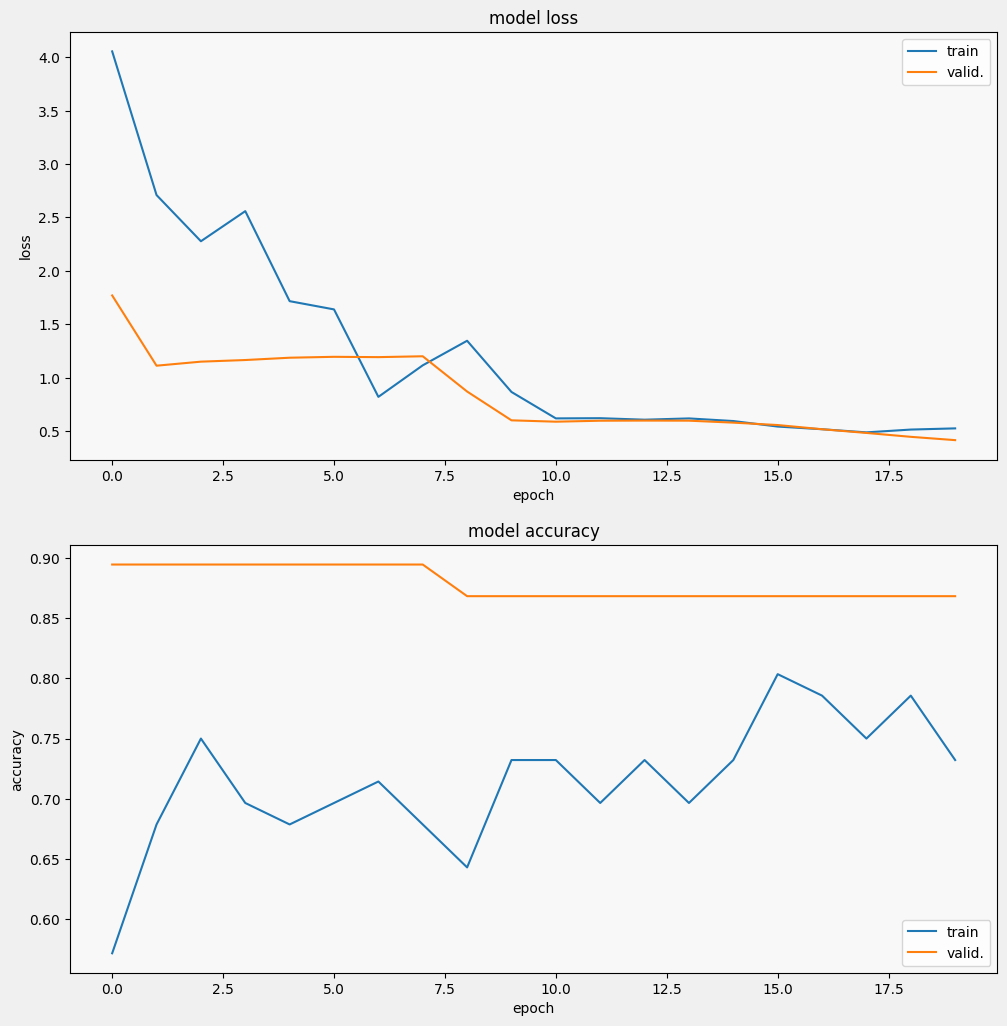

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy',
    212,
)

In [ ]:
loss, accuracy = new_model.evaluate(test_ds)
print(loss)
print(accuracy)

# accuracy
print(f'Train Accuracy: {history.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {history.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: { accuracy * 100:.2f}')
# loss
print(f'Train Loss: {history.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {history.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {loss * 100:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8440 - loss: 0.4773
0.4157387316226959
0.8684210777282715
Train Accuracy: 73.21
Val Accuracy: 86.84
Test Accuracy: 86.84
Train Loss: 52.58
Val Loss: 41.57
Test Loss: 41.57


In [ ]:
y_predict = new_model.predict(test_ds)
y_predict = np.argmax(y_predict, axis=1)
print(y_predict)

3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


In [ ]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


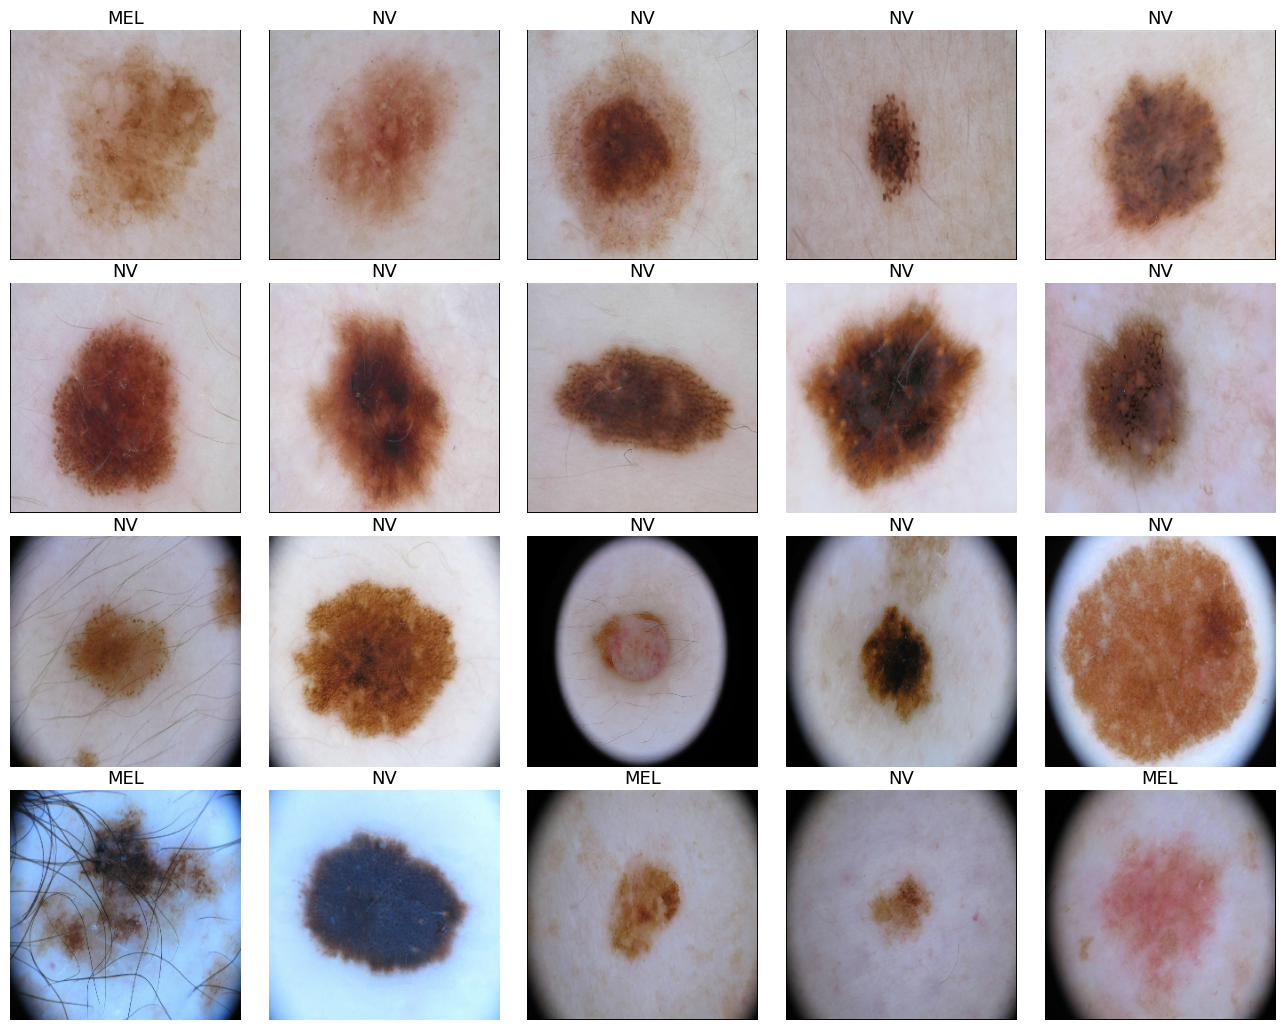

In [ ]:
dataset = test_ds.unbatch().batch(20)
batch = iter(dataset)

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)